In [26]:
import torch
import torch.nn as nn

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=2, padding=1),  # 32x32 → 16x16
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units * 2, kernel_size=3, stride=2, padding=1),  # 16x16 → 8x8
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 2, out_channels=hidden_units * 4, kernel_size=3, stride=2, padding=1),  # 8x8 → 4x4
            nn.ReLU()
        )

        # Latent dimensions
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(in_features=hidden_units * 4 * 4 * 4, out_features=128)
        self.fc_log_var = nn.Linear(in_features=hidden_units * 4 * 4 * 4, out_features=128)
        self.fc_decoder = nn.Linear(in_features=128, out_features=hidden_units * 4 * 4 * 4)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(hidden_units * 4, 4, 4))

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_units * 4, out_channels=hidden_units * 2, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 → 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_units * 2, out_channels=hidden_units, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_units, out_channels=output_shape, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 → 32x32
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        flat = self.flatten(encoded)
        mu = self.fc_mu(flat)
        log_var = self.fc_log_var(flat)
        z = self.reparameterize(mu, log_var)
        z = self.fc_decoder(z)
        z = self.unflatten(z)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var


In [27]:
def vae_loss(x_hat, x, mu, log_var):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')

    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    total_loss = recon_loss + kl_loss
    return total_loss, recon_loss.item(), kl_loss.item()

In [28]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=62, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=62, shuffle=False)

In [29]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VariationalAutoencoder(input_shape=3, hidden_units=32, output_shape=3).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [30]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_epoch_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        x_hat, mu, log_var = model(images)
        total_loss, recon_loss, kl_loss = vae_loss(x_hat, images, mu, log_var)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        total_epoch_loss += total_loss.item()
        total_recon_loss += recon_loss
        total_kl_loss += kl_loss

    print(f"Epoch {epoch+1}/{epochs} | Total: {total_epoch_loss:.4f} | Recon: {total_recon_loss:.4f} | KL: {total_kl_loss:.4f}")

Epoch 1/3 | Total: 5289938.1096 | Recon: 4487231.8187 | KL: 802706.2864
Epoch 2/3 | Total: 4064081.6824 | Recon: 3085066.3978 | KL: 979015.2892
Epoch 3/3 | Total: 3936520.8562 | Recon: 2911682.1582 | KL: 1024838.6910


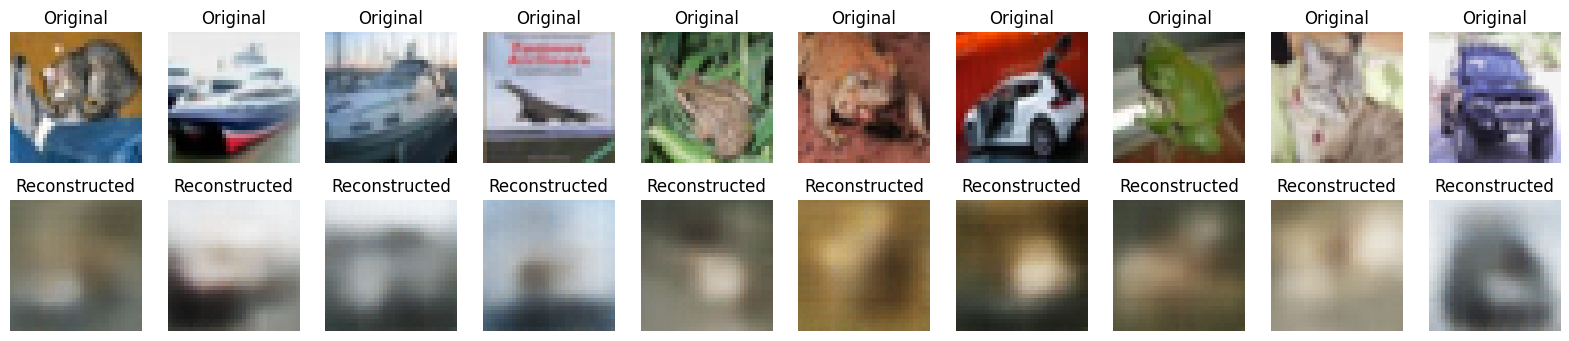

In [31]:
import matplotlib.pyplot as plt

model.eval()
with torch.inference_mode():
    for images, _ in test_loader:
        images = images.to(device)
        x_hat, _, _ = model(images)
        break

images = images.cpu()
x_hat = x_hat.cpu()

# Show 10 images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_hat[i].permute(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis("off")